We load the various dependencies

In [1]:
import cv2
import re
from pathlib import Path
from lib_1.utils import BackgroundGenerator, get_image_paths, get_folder
from lib_1.faces_detect import detect_faces
from lib_1.FaceFilter import FaceFilter
from tqdm import tqdm
from lib_1.PluginLoader import PluginLoader

%pylab inline
import matplotlib.pyplot as plt

from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from lib_1.PixelShuffler import PixelShuffler

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


We define the caracteristics of our network:
   * model_dir: the location of the model (it needs to be the absolute path)
   * conv_name: the kind of converter to use ("Masked" or "Adjust")
   * swap_model: Swap the model. Instead of A -> B, swap B -> A.
   * blur_size: Blur size. (it only work for Masked converter)
   * seamless_clone: Seamless mode
   * mask_type: the type of mask to use to replace faces.("rect", "facehull", "facehullandrect")
   * erosion_kernel_size: the erosion kernel size. (it only work for the masked converter)
   * smooth_mask: use Smooth mask (it only work for the Adjust converter)
   * avg_color_adjust: average the color (it only work for the Adjust converter)
   * input_dir: the location of the input images (it needs to be the absolute path)
   * output_dir: the location of the output images (it needs to be the absolute path)
   * filter_image: the image that will be used to filter faces 
   
I invite you to try different parameter until you get a satifying result.

In [2]:
model_dir="/home/olivier/Desktop/face-swap/deepfakes/weight"
conv_name = "Masked"
swap_model= False
blur_size=2
seamless_clone=False
mask_type="facehullandrect"
erosion_kernel_size=None
smooth_mask=True
avg_color_adjust=True
input_dir="/home/olivier/Desktop/face-swap/deepfakes3/data"
output_dir="/home/olivier/Desktop/face-swap/deepfakes3/test"
filter_image="filter/000001.jpg"

#DONT MODIFY 
IMAGE_SHAPE = (64, 64, 3)
ENCODER_DIM = 1024
encoderH5 = '/encoder.h5'
decoder_AH5 = '/decoder_A.h5'
decoder_BH5 = '/decoder_B.h5'
model_name = "Original" # TODO Pass as argument


We define several methods to get the images from the input file and extract the faces from them.

Important the extraction is done on the CPU side via libraries such as dlib (face recognition)

The faces are extracted as landmarks, and can be displayed as following 

~~~~
extractor = PluginLoader.get_extractor("Align")()
resized_image = extractor.extract(image, face, 256)

~~~~



In [9]:
def load_filter():
    filter_file = filter_image # TODO Pass as argument
    if Path(filter_file).exists():
        print('Loading reference image for filtering')
        return FaceFilter(filter_file)

def get_faces(image):
    faces_count = 0
    filterDeepFake = load_filter()
    extractor = PluginLoader.get_extractor("Align")()
    for face in detect_faces(image):
        
        if filterDeepFake is not None and not filterDeepFake.check(face):
            print('Skipping not recognized face!')
            continue
        resized_image = extractor.extract(image, face, 256)
        imgplot = plt.imshow(cv2.cvtColor(        resized_image , cv2.COLOR_BGR2RGB ))
        plt.show()

        yield faces_count, face
        faces_count +=1


def get_list_images_faces():
    input_list = get_image_paths(input_dir)
    listFile=[]
    for filename in tqdm(input_list):
        listFile.append(filename)
    for filename in listFile:
        image = cv2.imread(filename)
        yield filename, image, get_faces(image)
        


We define a function to run our model on all the faces in one image via the method `converter.patch_image(image, face)`

In [4]:
def convert(converter, item):
    try:
        (filename, image, faces) = item
        for idx, face in faces:
            image1 = converter.patch_image(image, face)
        output_file = str(output_dir)+ str("/")+ str(Path(filename).name)
        
        cv2.imwrite(str(output_file), image1)
    except Exception as e:
        print('Failed to convert image: {}. Reason: {}'.format(filename, e))


We define the autoencoder as for the training.

In [5]:
class Model():
    def __init__(self):

        self.model_dir = model_dir
        self.encoder = self.Encoder()
        self.decoder_A = self.Decoder()
        self.decoder_B = self.Decoder()

        self.initModel()

    
    def initModel(self):
        optimizer = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999)
        x = Input(shape=IMAGE_SHAPE)

        self.autoencoder_A = KerasModel(x, self.decoder_A(self.encoder(x)))
        self.autoencoder_B = KerasModel(x, self.decoder_B(self.encoder(x)))

        self.autoencoder_A.compile(optimizer=optimizer, loss='mean_absolute_error')
        self.autoencoder_B.compile(optimizer=optimizer, loss='mean_absolute_error')

    def converter(self, swap):
        autoencoder = self.autoencoder_B if not swap else self.autoencoder_A 
        return lambda img: autoencoder.predict(img)

    def conv(self, filters):
        def block(x):
            x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            return x
        return block

    def upscale(self, filters):
        def block(x):
            x = Conv2D(filters * 4, kernel_size=3, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            x = PixelShuffler()(x)
            return x
        return block

    def Encoder(self):
        input_ = Input(shape=IMAGE_SHAPE)
        x = input_
        x = self.conv(128)(x)
        x = self.conv(256)(x)
        x = self.conv(512)(x)
        x = self.conv(1024)(x)
        x = Dense(ENCODER_DIM)(Flatten()(x))
        x = Dense(4 * 4 * 1024)(x)
        x = Reshape((4, 4, 1024))(x)
        x = self.upscale(512)(x)
        return KerasModel(input_, x)

    def Decoder(self):
        input_ = Input(shape=(8, 8, 512))
        x = input_
        x = self.upscale(256)(x)
        x = self.upscale(128)(x)
        x = self.upscale(64)(x)
        x = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
        return KerasModel(input_, x)
        
    def load(self, swapped):
        (face_A,face_B) = (decoder_AH5, decoder_BH5) if not swapped else (decoder_BH5, decoder_AH5)

        try:
            self.encoder.load_weights(self.model_dir + encoderH5)
            self.decoder_A.load_weights(self.model_dir + face_A)
            self.decoder_B.load_weights(self.model_dir + face_B)
            print('loaded model weights')
            return True
        except Exception as e:
            print('Failed loading existing training data.')
            print(e)
            return False

    def save_weights(self):
        self.encoder.save_weights(self.model_dir + encoderH5)
        self.decoder_A.save_weights(self.model_dir + decoder_AH5)
        self.decoder_B.save_weights(self.model_dir + decoder_BH5)
        print('saved model weights')




The face swapping is performed in 3 steps:
    1. We create our model object via `PluginLoader.get_model(model_name)(model_dir)`
    2. We load our previously trained model in our object
    3. We parse all the input picture and we extract the landmarks associated with every face via `get_list_images_faces`
    4. We run our model on each face via `convert(converter, item)`.

100%|██████████| 9/9 [00:00<00:00, 33465.19it/s]

loaded model weights
Loading Convert from Convert_Masked plugin...
Loading reference image for filtering


Loading Extract from Extract_Align plugin...
-----
check
[ 0.95202737]
Skipping not recognized face!
check
[ 0.47222241]


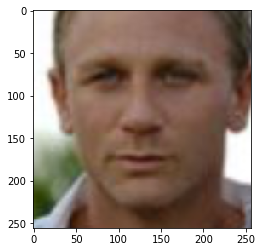

check
[ 0.99528691]
Skipping not recognized face!
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[ 0.45463534]


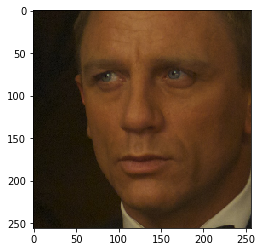

In [ ]:

model = Model()
if not model.load(swap_model):
    print('Model Not Found! A valid model must be provided to continue!')
    exit(1)

faceswap_converter = PluginLoader.get_converter(conv_name)(model.converter(False),
    blur_size=blur_size,
    seamless_clone=seamless_clone,
    mask_type=mask_type,
    erosion_kernel_size=erosion_kernel_size,
    smooth_mask=smooth_mask,
    avg_color_adjust=avg_color_adjust
)

list_faces=get_list_images_faces()

    
batch = BackgroundGenerator(list_faces, 1)

for item in batch.iterator():
    convert(faceswap_converter, item)